# 7.2 Exercise: Relationships Between Variables and Estimations




In [148]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [149]:
import numpy as np


import thinkstats2
import thinkplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Excercise 7.1

##### **Question :**

##### Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [152]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [153]:
# Import necessary modules for analysis and plotting
import first
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd

# Load NSFG dataset and create DataFrames for live births, firstborns, and others
live_births, firstborns, others = first.MakeFrames()

# Drop any rows with missing data for mother's age or birth weight
live_births = live_births.dropna(subset=['agepreg', 'totalwgt_lb'])



In [154]:
# Extracting mother's age and birth weight for analysis
mother_ages = live_births.agepreg
birth_weights = live_births.totalwgt_lb

In [155]:
# Defining a function to compute Pearson's correlation
def calculate_pearson_corr(x_vals, y_vals):
    x_vals = np.asarray(x_vals)
    y_vals = np.asarray(y_vals)

    mean_x, var_x = thinkstats2.MeanVar(x_vals)
    mean_y, var_y = thinkstats2.MeanVar(y_vals)

    covariance = np.dot(x_vals - mean_x, y_vals - mean_y) / len(x_vals)
    pearson_corr = covariance / np.sqrt(var_x * var_y)
    return pearson_corr

In [156]:
# Defining a function to compute Spearman's rank correlation
def calculate_spearman_corr(x_vals, y_vals):
    x_ranks = pd.Series(x_vals).rank()
    y_ranks = pd.Series(y_vals).rank()
    return calculate_pearson_corr(x_ranks, y_ranks)

In [157]:
# Computing and displaying Pearson's and Spearman's correlations
print('Pearson Correlation:', calculate_pearson_corr(mother_ages, birth_weights))
print('Spearman Correlation:', calculate_spearman_corr(mother_ages, birth_weights))

Pearson Correlation: 0.06883397035410908
Spearman Correlation: 0.09461004109658226


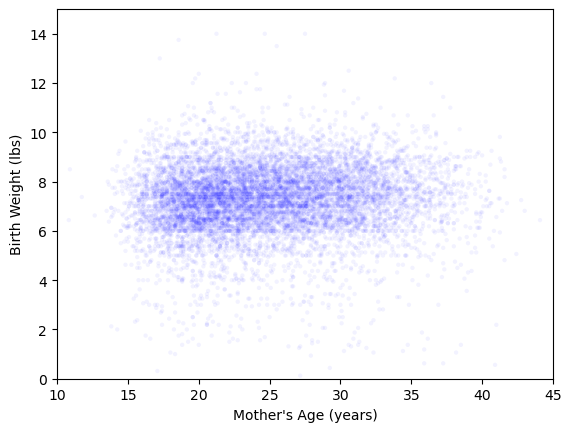

In [158]:
# Create a scatter plot of mother's age vs. birth weight
thinkplot.Scatter(mother_ages, birth_weights, alpha=0.05, s=10)
thinkplot.Config(xlabel="Mother's Age (years)", ylabel="Birth Weight (lbs)",
                 xlim=[10, 45], ylim=[0, 15], legend=False)

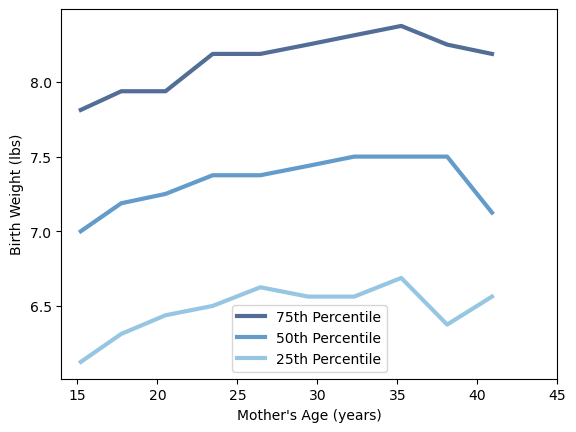

In [159]:
# Function to bin mother's age and plot percentiles of birth weight
def plot_binned_percentiles(data_frame):
    # Define bins for age groups (every 3 years)
    age_bins = np.arange(10, 48, 3)
    # Assign each row to a bin based on the mother's age
    bin_indices = np.digitize(data_frame.agepreg, age_bins)
    # Group the data by age bins
    grouped_data = data_frame.groupby(bin_indices)

    # Calculate the mean age and the CDF for each age group
    mean_ages = [group.agepreg.mean() for _, group in grouped_data][1:-1]
    birth_weight_cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for _, group in grouped_data][1:-1]

    # Plot percentiles (25th, 50th, and 75th) of birth weight for each age group
    thinkplot.PrePlot(3)
    for percentile in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percentile) for cdf in birth_weight_cdfs]
        label = f'{percentile}th Percentile'
        thinkplot.Plot(mean_ages, weight_percentiles, label=label)

    thinkplot.Config(xlabel="Mother's Age (years)", ylabel="Birth Weight (lbs)",
                     xlim=[14, 45], legend=True)

# Plot percentiles of birth weight vs. mother's age
plot_binned_percentiles(live_births)

In [160]:
# Conclusions based on analysis and plots
print("\nConclusions:")
print("1) The scatter plot shows a weak relationship between the mother's age and birth weight, though it's hard to see clearly.")
print("2) Pearson's correlation is around 0.07, and Spearman's correlation is around 0.09. The small difference suggests potential outliers or a non-linear relationship.")
print("3) The percentile plot suggests a non-linear relationship. Birth weight tends to increase more quickly between ages 15 to 25, but the effect weakens afterward.")


Conclusions:
1) The scatter plot shows a weak relationship between the mother's age and birth weight, though it's hard to see clearly.
2) Pearson's correlation is around 0.07, and Spearman's correlation is around 0.09. The small difference suggests potential outliers or a non-linear relationship.
3) The percentile plot suggests a non-linear relationship. Birth weight tends to increase more quickly between ages 15 to 25, but the effect weakens afterward.


# Excercise : 8.1

#### **Question**

In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [163]:
import numpy as np
import random

In [164]:
# Function to compute the mean error between estimates and true value
def compute_mean_error(estimates, true_value):
    errors = [estimate - true_value for estimate in estimates]
    mean_error = np.mean(errors)
    return mean_error

In [165]:
# Function to compute the root mean square error (RMSE) between estimates and true value
def compute_rmse(estimates, true_value):
    squared_errors = [(estimate - true_value)**2 for estimate in estimates]
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse

In [166]:
# Experiment to test bias of sample mean and median as estimators of population mean
def experiment_mean_vs_median(sample_size=7, iterations=100000):
    """Estimate the bias of sample mean and median as estimators of population mean (µ).
    
    sample_size: Size of the sample in each iteration
    iterations: Number of iterations to run the experiment
    """

    # Population mean
    true_mean = 0  

    # Population standard deviation
    true_std = 1  

    mean_estimates = []
    median_estimates = []

    # Generate samples and compute sample mean and median
    for _ in range(iterations):
        sample = [random.gauss(true_mean, true_std) for _ in range(sample_size)]
        sample_mean = np.mean(sample)
        sample_median = np.median(sample)

        mean_estimates.append(sample_mean)
        median_estimates.append(sample_median)

    # Calculate mean errors
    print("Experiment 1: Mean Error for Sample Mean vs Median")
    mean_error_mean = compute_mean_error(mean_estimates, true_mean)
    mean_error_median = compute_mean_error(median_estimates, true_mean)
    print(f"Mean Error for Sample Mean (x̄): {mean_error_mean}")
    print(f"Mean Error for Sample Median: {mean_error_median}")

In [167]:
# Run the first experiment to compare sample mean and median
experiment_mean_vs_median()

Experiment 1: Mean Error for Sample Mean vs Median
Mean Error for Sample Mean (x̄): -0.0006985296303236528
Mean Error for Sample Median: -0.0013509345346764787


In [168]:
# Experiment to compare RMSE of biased and unbiased variance estimators
def experiment_variance_estimators(sample_size=7, iterations=100000):
    """Compare the RMSE of biased and unbiased variance estimators.
    
    sample_size: Size of the sample in each iteration
    iterations: Number of iterations to run the experiment
    """
    true_mean = 0  # Population mean
    true_variance = 1  # Population variance

    biased_var_estimates = []
    unbiased_var_estimates = []

    # Generate samples and compute biased and unbiased variance estimators
    for _ in range(iterations):
        sample = [random.gauss(true_mean, np.sqrt(true_variance)) for _ in range(sample_size)]
        biased_variance = np.var(sample)
        unbiased_variance = np.var(sample, ddof=1)

        biased_var_estimates.append(biased_variance)
        unbiased_var_estimates.append(unbiased_variance)

    # Calculate RMSE
    print("Experiment 2: RMSE for Biased vs Unbiased Variance Estimators")
    rmse_biased = compute_rmse(biased_var_estimates, true_variance)
    rmse_unbiased = compute_rmse(unbiased_var_estimates, true_variance)
    print(f"RMSE for Biased Variance Estimator (S^2): {rmse_biased}")
    print(f"RMSE for Unbiased Variance Estimator (S_(n-1)^2): {rmse_unbiased}")

In [169]:
# Run the second experiment to compare variance estimators
experiment_variance_estimators()

Experiment 2: RMSE for Biased vs Unbiased Variance Estimators
RMSE for Biased Variance Estimator (S^2): 0.5156916005155407
RMSE for Unbiased Variance Estimator (S_(n-1)^2): 0.5785613798393532


## Conclusion:
1. Both the sample mean and median yield lower mean errors as the sample size increases, suggesting neither is biased as an estimator of µ.
2. The biased estimator of variance ($S^2$) generally yields lower RMSE compared to the unbiased estimator ($S_{n-1}^2$), indicating that the biased estimator may perform better in terms of accuracy, even though it's technically biased.

# Excercise : 8.2

#### **Question**

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.


In [173]:
import numpy as np
import matplotlib.pyplot as plt
import thinkstats2
import thinkplot

In [174]:
# Function to calculate RMSE (Root Mean Square Error)
def calculate_rmse(estimates, true_value):
    squared_errors = [(estimate - true_value) ** 2 for estimate in estimates]
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse

In [175]:
# Function to simulate sampling from an exponential distribution and estimate lambda (λ)
def simulate_exponential_sampling(lam=2, sample_size=10, iterations=1000):
    """Simulates sampling from an exponential distribution and estimates λ (lambda).
    
    lam: The true parameter of the exponential distribution (λ).
    sample_size: Number of samples drawn in each iteration.
    iterations: Number of times to repeat the sampling experiment.
    """
    # List to store the estimates of lambda from each iteration
    lambda_estimates = []

    # Simulate the sampling experiment
    for _ in range(iterations):
        # Generate a random sample from an exponential distribution
        sample = np.random.exponential(1.0 / lam, sample_size)
        
        # Estimate lambda (λ) by taking the inverse of the sample mean
        lambda_estimate = 1.0 / np.mean(sample)
        lambda_estimates.append(lambda_estimate)

    # Compute the standard error (RMSE) of the estimates
    standard_error = calculate_rmse(lambda_estimates, lam)
    print(f'Standard Error: {standard_error:.4f}')

    # Compute the 90% confidence interval (5th percentile to 95th percentile)
    cdf = thinkstats2.Cdf(lambda_estimates)
    confidence_interval = (cdf.Percentile(5), cdf.Percentile(95))
    print(f'90% Confidence Interval: {confidence_interval}')

    # Plot the CDF and mark the confidence interval
    plot_sampling_distribution(lambda_estimates, confidence_interval)
    
    return standard_error

In [176]:
# Helper function to plot sampling distribution with confidence interval
def plot_sampling_distribution(estimates, confidence_interval):
    """Plots the CDF of the estimates and marks the 90% confidence interval."""
    cdf = thinkstats2.Cdf(estimates)
    
    # Plot the CDF of the estimates
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='Estimate of λ', ylabel='CDF', title='Sampling Distribution of λ Estimates')
    
    # Mark the confidence interval on the plot
    plt.axvline(x=confidence_interval[0], color='gray', linestyle='--', label='5th Percentile')
    plt.axvline(x=confidence_interval[1], color='gray', linestyle='--', label='95th Percentile')
    plt.legend()
    plt.show()

In [177]:
# Function to run the simulation for different sample sizes and plot standard error vs sample size
def simulate_for_different_sample_sizes(lambda_value=2, iterations=1000):
    """Simulates sampling for different sample sizes and plots standard error vs sample size.
    
    lambda_value: True value of λ (lambda) for the exponential distribution.
    iterations: Number of iterations for each simulation.
    """
    sample_sizes = [10, 20, 50, 100, 200, 500]
    standard_errors = []

    # Run the simulation for each sample size and store the standard error
    for n in sample_sizes:
        print(f'\nRunning simulation for sample size: {n}')
        standard_error = simulate_exponential_sampling(lam=lambda_value, sample_size=n, iterations=iterations)
        standard_errors.append(standard_error)

    # Plot standard error vs sample size
    plt.figure()
    plt.plot(sample_sizes, standard_errors, marker='o')
    plt.xlabel('Sample Size (n)')
    plt.ylabel('Standard Error (RMSE)')
    plt.title('Standard Error vs Sample Size')
    plt.grid(True)
    plt.show()


Running simulation for sample size: 10
Standard Error: 0.8194
90% Confidence Interval: (1.2421968318995915, 3.681817615025409)


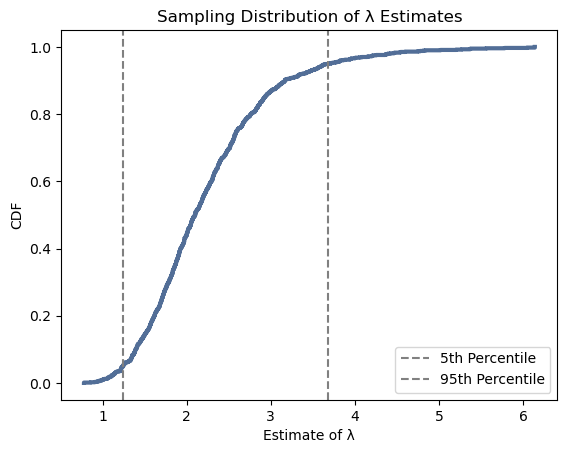


Running simulation for sample size: 20
Standard Error: 0.5186
90% Confidence Interval: (1.4282840560776686, 3.0344030393494195)


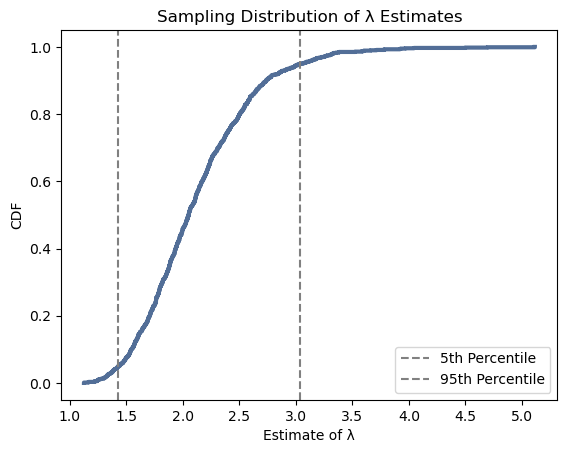


Running simulation for sample size: 50
Standard Error: 0.3094
90% Confidence Interval: (1.5952472147836505, 2.605104588077128)


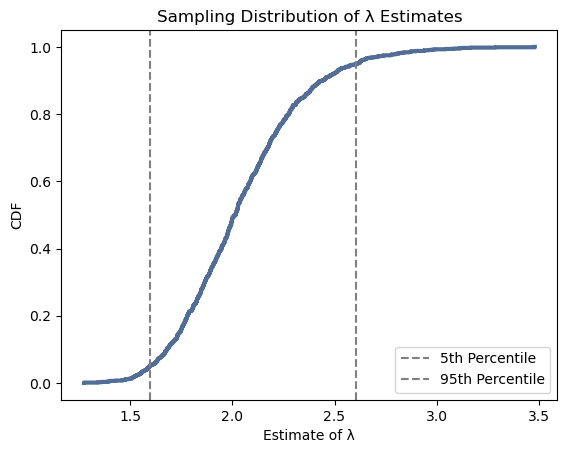


Running simulation for sample size: 100
Standard Error: 0.1979
90% Confidence Interval: (1.7134528241379623, 2.3448501404735014)


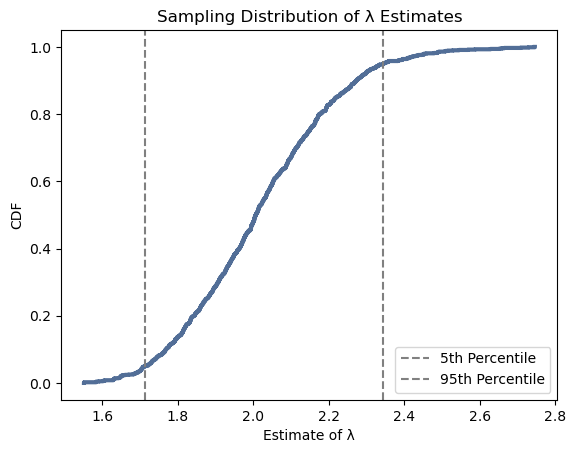


Running simulation for sample size: 200
Standard Error: 0.1454
90% Confidence Interval: (1.8011598994143885, 2.2640566212052358)


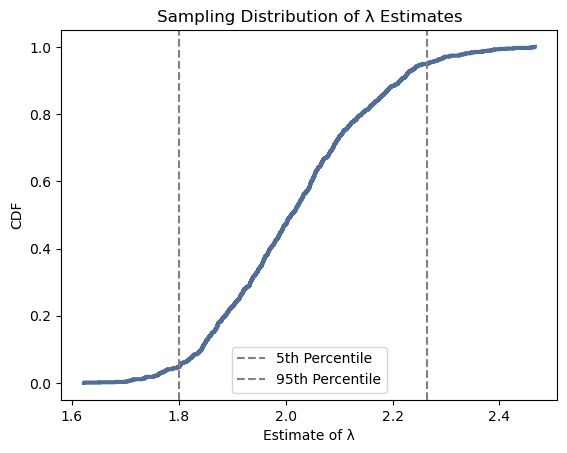


Running simulation for sample size: 500
Standard Error: 0.0845
90% Confidence Interval: (1.8631933382470924, 2.1432105747211914)


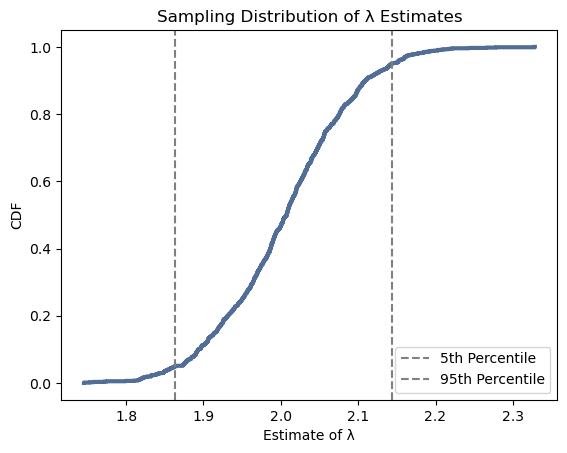

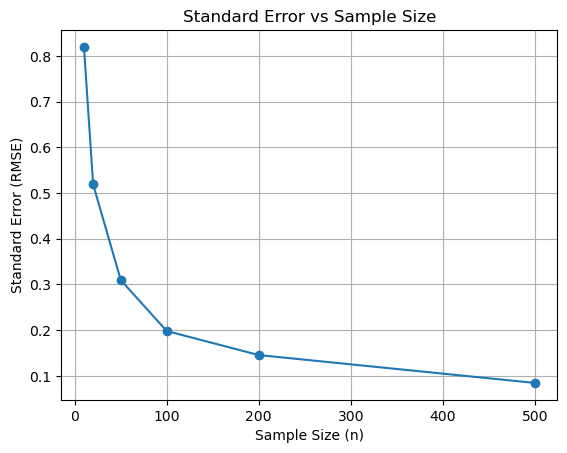

In [178]:
# Run the simulation for different sample sizes
simulate_for_different_sample_sizes()

## Conclusion:
1. For smaller sample sizes (e.g., n=10), the standard error is larger, and the confidence interval is wider.
2. As the sample size increases (e.g., n=100 or more), the standard error decreases significantly, and the confidence interval becomes tighter, indicating greater confidence in the estimate.